<a href="https://colab.research.google.com/github/diego2017003/Mlops_student_freedata_analysis_pipeline/blob/main/Models/mlops0/mlops_segregation_and_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import argparse
import logging
import os
import yaml
import seaborn as sns
from sklearn.impute import SimpleImputer
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.neighbors import LocalOutlierFactor
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
#from clearml import StorageManager

### 1. Rascunho e exploração de modelos
---

In [3]:
# !pip install clearml

In [4]:
# !pip install clearml

In [5]:
# !pip install clearml numpy clearml-agent 'pyjwt<1.8.0'

In [6]:
# %%bash

# export api=`cat <<EOF
# api {
#     # Stef Telford's workspace
#     web_server: https://app.community.clrml.com
#     api_server: https://api.community.clrml.com
#     files_server: https://files.community.clrml.com
#     credentials {
#         "access_key" = "3ZJX3UQ9YS87PD4A1G"
#         "secret_key" = "=OfK#N@Y&mFtC)VHWVqTJIb52QUZPfuJ&bSYD4!uUk(t7ENv"
#     }
# }
# EOF
# `
# echo "$api" > /root/clearml.conf

In [7]:
# !clearml-agent daemon --queue default

In [8]:
# from clearml import StorageManager

# manager = StorageManager()
# dataset_path = manager.get_local_copy(
#     remote_url="https://files.clear.ml/a%20ML%20example/Prepreocessing.e08834ed846640c68d05d7b6d81b99e1/artifacts/processed_data/preprocessed_data.csv"
# )

In [9]:
data = pd.read_csv("preprocessed_data(1).csv",sep=',',encoding='utf-8')

In [10]:
# c = data.columns
# for i in c:
#   print(i)
#   print(data[i].value_counts())


In [11]:
data.area_conhecimento.value_counts()

Ciências da Saúde              2042
Ciências Exatas e da Terra     1745
Ciências Sociais Aplicadas     1128
Engenharias                    1050
Ciências Humanas                865
Linguística, Letras e Artes     724
Ciências Biológicas             535
Ciências Agrárias               191
Outra                            61
Name: area_conhecimento, dtype: int64

In [12]:
data['sexo'].replace({"M":"0","F":"1","false":"2"},inplace=True)
data['idade'] = 2020 - data['ano_nascimento'].astype(int)
data['local_ou_de_fora'] = (data['estado_origem']==('Rio Grande do Norte'))
data['raca'].fillna(value='Não Informado',inplace=True)
data['area_conhecimento'].fillna(value='Outra',inplace=True)
data['grau_academico'].fillna(value='OUTRO',inplace=True)
data['grau_academico'].replace({'BACHARELADO':'3', 'LICENCIATURA':'2', 'TECNOLÓGICO':'1',"OUTRO":"0"},inplace=True)
data['descricao'].replace({'APROVADO':'1',"FALHOU":"0","REPROVADO POR NOTA E FALTA":"0"},inplace=True)

In [13]:
data['raca'].unique()

array(['Negro', 'Branco', 'Pardo', 'Não Informado',
       'Amarelo (de origem oriental)', 'Indígena',
       'Remanescente de quilombo'], dtype=object)

In [14]:
X = data.drop(columns=['descricao'])
y = data['descricao']

In [15]:
!pip install imbalanced-learn

In [16]:
# from imblearn.under_sampling import RandomUnderSampler
# undersample = RandomUnderSampler(sampling_strategy=0.5)
# X_over, y_over = undersample.fit_resample(X, y)

In [17]:
# X_over['descricao'] = y_over
# data = X_over

In [18]:
# data.replace({"<":''},inplace=True)

In [19]:
#data.drop(columns=['ano_nascimento'],inplace=True)

In [20]:
data.columns

Index(['sexo', 'ano_nascimento', 'raca', 'estado_origem', 'cidade_origem',
       'renda', 'possui_auxilio_alimentacao', 'possui_auxilio_transporte',
       'possui_auxilio_residencia_moradia', 'grau_academico',
       'area_conhecimento', 'descricao', 'idade', 'local_ou_de_fora'],
      dtype='object')

In [21]:
#One label encoder 
from sklearn import preprocessing
columns = ['sexo', 'raca','possui_auxilio_alimentacao', 'possui_auxilio_transporte',
       'possui_auxilio_residencia_moradia', 'grau_academico',
       'area_conhecimento', 'descricao','local_ou_de_fora']
for i in columns:
  le = LabelEncoder()
  print(data[i].unique())
  le.fit(data[i].unique())
  data[i+"_le"] = le.transform(data[i])

['0' '1' '2']
['Negro' 'Branco' 'Pardo' 'Não Informado' 'Amarelo (de origem oriental)'
 'Indígena' 'Remanescente de quilombo']
[False  True]
[False  True]
[False  True]
['3' '2' '1' '0']
['Ciências Biológicas' 'Ciências da Saúde' 'Ciências Exatas e da Terra'
 'Engenharias' 'Ciências Sociais Aplicadas' 'Ciências Humanas'
 'Linguística, Letras e Artes' 'Ciências Agrárias' 'Outra']
['1' '0']
[False  True]


In [22]:
data = data.loc[:,['idade','renda','sexo_le', 'raca_le',
                   'possui_auxilio_alimentacao_le',
       'possui_auxilio_transporte_le', 'possui_auxilio_residencia_moradia_le',
       'grau_academico_le', 'area_conhecimento_le', 'local_ou_de_fora_le','descricao_le']]

In [23]:
# sns.pairplot(data=data,hue='descricao_le')

In [24]:
# !pip install pycaret

In [25]:
# from pycaret.classification import *

# exp_name = setup(data = data,  target = 'descricao_le')

# best_model = compare_models()

In [26]:
# best_model

In [27]:
x_train,x_test,y_train,y_test = train_test_split(data.drop(columns=['descricao_le']),
                                                      data['descricao_le'],
                                                      test_size=0.2,
                                                      random_state=2,
                                                      shuffle=True,
                                                      stratify = data['descricao_le'])

In [28]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=194, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False).fit(x_train, y_train)

In [29]:
y_predict = lr.predict(x_test)

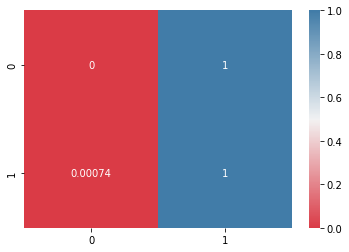

In [30]:
cm = confusion_matrix(y_true=y_test,y_pred=y_predict,normalize='true')

cmap = sns.diverging_palette(10, 240, as_cmap=True)

sns.heatmap(cm,cmap=cmap, annot=True)

In [31]:
print(classification_report(y_true=y_test,y_pred=y_predict))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       318
           1       0.81      1.00      0.89      1351

    accuracy                           0.81      1669
   macro avg       0.40      0.50      0.45      1669
weighted avg       0.66      0.81      0.72      1669



In [32]:
import sklearn
sklearn.metrics.SCORERS

{'accuracy': make_scorer(accuracy_score),
 'adjusted_mutual_info_score': make_scorer(adjusted_mutual_info_score),
 'adjusted_rand_score': make_scorer(adjusted_rand_score),
 'average_precision': make_scorer(average_precision_score, needs_threshold=True),
 'balanced_accuracy': make_scorer(balanced_accuracy_score),
 'completeness_score': make_scorer(completeness_score),
 'explained_variance': make_scorer(explained_variance_score),
 'f1': make_scorer(f1_score, average=binary),
 'f1_macro': make_scorer(f1_score, pos_label=None, average=macro),
 'f1_micro': make_scorer(f1_score, pos_label=None, average=micro),
 'f1_samples': make_scorer(f1_score, pos_label=None, average=samples),
 'f1_weighted': make_scorer(f1_score, pos_label=None, average=weighted),
 'fowlkes_mallows_score': make_scorer(fowlkes_mallows_score),
 'homogeneity_score': make_scorer(homogeneity_score),
 'jaccard': make_scorer(jaccard_score, average=binary),
 'jaccard_macro': make_scorer(jaccard_score, pos_label=None, average=mac

In [33]:
# from sklearn.model_selection import GridSearchCV
# from sklearn.neural_network import MLPClassifier
# X = data.drop(columns=['descricao_le'])
# y = data['descricao_le']
# param_grid = [
#         {
#             'activation' : ['identity', 'logistic', 'tanh', 'relu'],
#             'learning_rate': ['constant', 'invscaling', 'adaptive'],
#             'solver' : ['lbfgs', 'sgd', 'adam'],
#             'hidden_layer_sizes': [
#              (1,1,),(1,2,),(1,3,),(1,4,),(1,5,),(2,1,),(2,2,),(2,3,),(2,4,),(2,5,),(3,1,),(3,2,),(3,3,),(3,4,),(3,5,)
#              ,(4,1,),(4,2,),(4,3,),(4,4,),(4,5,),(5,1,),(5,2,),(5,3,),(5,4,),(5,5,)
#              ]
#         }
#        ]
# clf = GridSearchCV(MLPClassifier(), param_grid, cv=3,scoring='precision')

# clf.fit(X,y)


# print("Best parameters set found on development set:")
# print(clf.best_params_)

In [34]:
#precision_mean_macro_{'activation': 'identity', 'hidden_layer_sizes': (1, 1), 'learning_rate': 'adaptive', 'solver': 'adam'}
#precision_{'activation': 'identity', 'hidden_layer_sizes': (5, 3), 'learning_rate': 'adaptive', 'solver': 'lbfgs'}

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       318
           1       0.81      1.00      0.89      1351

    accuracy                           0.81      1669
   macro avg       0.40      0.50      0.45      1669
weighted avg       0.66      0.81      0.72      1669



/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_sta

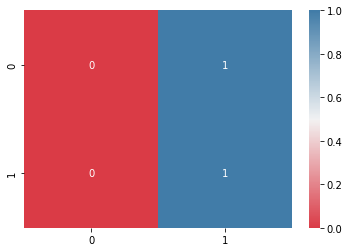

In [35]:
from sklearn.neural_network import MLPClassifier

mlp1 = MLPClassifier(activation= 'identity', hidden_layer_sizes= (1, 1), learning_rate= 'adaptive', solver= 'adam')
mlp2= MLPClassifier(activation= 'identity', hidden_layer_sizes= (5, 3), learning_rate= 'adaptive', solver= 'lbfgs')
mlp1.fit(x_train,y_train)
mlp2.fit(x_train,y_train)

y_pred1 = mlp1.predict(x_test)
y_pred2 = mlp2.predict(x_test)

cm = confusion_matrix(y_true=y_test,y_pred=y_pred1,normalize='true')

cmap = sns.diverging_palette(10, 240, as_cmap=True)
print(classification_report(y_true=y_test,y_pred=y_pred1))
sns.heatmap(cm,cmap=cmap, annot=True)

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       318
           1       0.81      1.00      0.89      1351

    accuracy                           0.81      1669
   macro avg       0.40      0.50      0.45      1669
weighted avg       0.66      0.81      0.72      1669



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


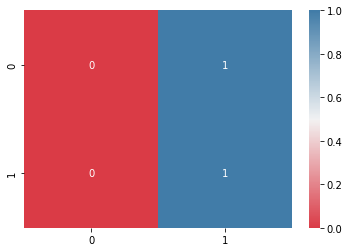

In [36]:
cm = confusion_matrix(y_true=y_test,y_pred=y_pred2,normalize='true')

cmap = sns.diverging_palette(10, 240, as_cmap=True)
print(classification_report(y_true=y_test,y_pred=y_pred2))
sns.heatmap(cm,cmap=cmap, annot=True)

In [37]:
from joblib import dump, load
dump(lr, 'regressao_logistica.joblib')
dump(mlp1, 'mlp_better_accuracy.joblib')
dump(mlp2, 'mlp_better_precision.joblib')

['mlp_better_precision.joblib']

### 2. Criação do modelo 
---

In [38]:
# configure logging
logging.basicConfig(level=logging.INFO,
                    format="%(asctime)s %(message)s",
                    datefmt='%d-%m-%Y %H:%M:%S')

# reference for a logging obj
logger = logging.getLogger()


In [39]:
#Custom Transformer that extracts columns passed as argument to its constructor 
class FeatureSelector( BaseEstimator, TransformerMixin ):
    #Class Constructor 
    def __init__( self, feature_names ):
        self.feature_names = feature_names 
    
    #Return self nothing else to do here    
    def fit( self, X, y = None ):
        return self 
    
    #Method that describes what we need this transformer to do
    def transform( self, X, y = None ):
        print(self.feature_names)
        print(X.columns)
        return X[ self.feature_names ]

In [40]:
# Handling categorical features 
class CategoricalTransformer( BaseEstimator, TransformerMixin ):
    # Class constructor method that takes one boolean as its argument
    def __init__(self, new_features=True, colnames=None):
        self.new_features = new_features
        self.colnames = colnames

    #Return self nothing else to do here    
    def fit( self, X, y = None ):
        return self 

    def get_feature_names(self):
        return self.colnames.tolist()

    # Transformer method we wrote for this transformer 
    def transform(self, X , y = None):
        df = pd.DataFrame(X,columns=self.colnames)
        
        columns = self.colnames
        print(columns)
        c = []
        # Create new features with label Encoding
        for i in columns:
          df[i] = df[i].astype(str)
          df[i].fillna(value='não informado',inplace=True)
          le = LabelEncoder()
          print(i)
          le.fit(df[i].unique().astype(str))
          df[i+'_le'] = le.transform(df[i])
          c.append(i+'_le')
        
        print(df.head())
        # update column names
        self.colnames = df.columns      
        print(type(df.loc[:,c]))
        df = df.loc[:,c]
        return df

In [41]:
# transform numerical features
class NumericalTransformer( BaseEstimator, TransformerMixin ):
    # Class constructor method that takes a model parameter as its argument
    # model 0: minmax
    # model 1: standard
    # model 2: without scaler
    def __init__(self, model = 0, colnames=None):
        self.model = model
        self.colnames = colnames

    #Return self nothing else to do here    
    def fit( self, X, y = None ):
        return self

    # return columns names after transformation
    def get_feature_names(self):
        return self.colnames 

    #Transformer method we wrote for this transformer 
    def transform(self, X , y = None ):
        df = pd.DataFrame(X,columns=self.colnames)
        self.colnames = df.columns.tolist()
      

        if self.model == 0: 
            scaler = MinMaxScaler()
            # transform data
            df = scaler.fit_transform(df)
            
        elif self.model == 1:
            scaler = StandardScaler()
            # transform data
            df = scaler.fit_transform(df)
        else:
            df = df.values
        print(type(df))
        return df

In [46]:
import yaml
def process_args():

    data = pd.read_csv("/content/preprocessed_data(1).csv",encoding='utf-8',sep=',',dtype=object)
    with open('/content/config.yaml') as fp:
        args = yaml.load(fp)
    model_config = args['logistic_regression_pipeline']

    data['ano_nascimento'].fillna(value='2000',inplace=True)
    #create age feature
    data['idade'] = 2020 - data['ano_nascimento'].astype(int)
    data['ano_nascimento'] = data['ano_nascimento'].astype(int)
    data['renda'] = data['renda'].astype(int)
    # Spliting train.csv into train and validation dataset
    logger.info("Spliting data into train/val")
    #label replacement
    # Create logical instance from multivalue_feture
    data['local_ou_de_fora'] = (data['estado_origem']==('Rio Grande do Norte'))

    # Fill nan  for "Outro" category
    data['raca'].fillna(value='Não Informado',inplace=True)
    data['area_conhecimento'].fillna(value='Outra',inplace=True)
    data['grau_academico'].fillna(value='OUTRO',inplace=True)

    # Start label Encoder
    data['grau_academico'].replace({'BACHARELADO':'3', 'LICENCIATURA':'2', 'TECNOLÓGICO':'1',"OUTRO":"0"},inplace=True)

    data.drop(columns={'estado_origem','cidade_origem'},inplace=True)       
    # data['sexo'].fillna(value="FALSE",inplace=True)
    # data['sexo'] = data['sexo'].replace({"false":"FALSE"},inplace=True)
    # data['sexo'].replace({"M":0,"F":1,"FALSE":2},inplace=True)
    data['descricao'].replace({'APROVADO':'1',"FALHOU":"0","REPROVADO POR NOTA E FALTA":"0"},inplace=True)
    data['descricao'] = pd.to_numeric(data['descricao'],errors='coerce')
    data['descricao'].fillna(value='0',inplace=True)
    
    print(data.dtypes)
    # split-out train/validation and test dataset
    x_train,x_val,y_train,y_val = train_test_split(data.drop(columns=['descricao']),
                                                      data['descricao'],
                                                      test_size=0.2,
                                                      random_state=2,
                                                      shuffle=True,
                                                      stratify = data['descricao'])
    
    logger.info("x train: {}".format(x_train.shape))
    logger.info("y train: {}".format(y_train.shape))
    logger.info("x val: {}".format(x_val.shape))
    logger.info("y val: {}".format(y_val.shape))
    logger.info("x train: {}".format(list(x_train.columns)))
    logger.info("Removal Outliers")
    # temporary variable
    x = x_train.select_dtypes("int64").copy()

    # identify outlier in the dataset
    lof = LocalOutlierFactor()
    outlier = lof.fit_predict(x)
    mask = (outlier != -1)

    logger.info("x_train shape [original]: {}".format(x_train.shape))
    logger.info("x_train shape [outlier removal]: {}".format(x_train.loc[mask,:].shape))

    # dataset without outlier, note this step could be done during the preprocesing stage
    x_train = x_train.loc[mask,:].copy()
    y_train = y_train[mask].copy()
    logger.info("Encoding Target Variable")
    # define a categorical encoding for target variable
    le = LabelEncoder()

    # fit and transform y_train
    y_train = le.fit_transform(y_train)
    # transform y_test (avoiding data leakage)
    y_val = le.transform(y_val)
    print(y_train)
    logger.info("Classes [0, 1]: {}".format(le.inverse_transform([0, 1])))
    
    # Pipeline generation
    logger.info("Pipeline generation")
    
    # Categrical features to pass down the categorical pipeline 
    categorical_features = x_train.select_dtypes(["object",'bool']).columns.to_list()

    # Numerical features to pass down the numerical pipeline 
    numerical_features = x_train.select_dtypes("int64").columns.to_list()
    print(len(numerical_features)+len(categorical_features))
    # Defining the steps in the categorical pipeline 
    logger.info(FeatureSelector(categorical_features))
    categorical_pipeline = Pipeline(steps = [('cat_selector',FeatureSelector(categorical_features)),
                                            ('imputer_cat', SimpleImputer(strategy="most_frequent")),
                                             ('cat_encoder',OneHotEncoder(sparse=False,drop="first"))
                                            ]
                                   )
    # Defining the steps in the numerical pipeline     
    logger.info(FeatureSelector(numerical_features))
    
    numerical_pipeline = Pipeline(steps = [('num_selector', FeatureSelector(numerical_features)),
                                           ('imputer_cat', SimpleImputer(strategy="median")),
                                           ('num_transformer', NumericalTransformer(model_config["numerical_pipe"]["model"],
                                                                                   colnames=numerical_features))
                                          ]
                                 )

    # Combining numerical and categorical piepline into one full big pipeline horizontally 
    # using FeatureUnion
    full_pipeline_preprocessing = FeatureUnion(transformer_list = [('cat_pipeline', categorical_pipeline),
                                                                   ('num_pipeline', numerical_pipeline)
                                                                  ]
                                              )
   
    # The full pipeline 
    pipe = Pipeline(steps = [('full_pipeline', full_pipeline_preprocessing),
                             ("classifier",LogisticRegression())
                            ]
                   )

    # training 
    logger.info("Training{}".format(list(x_train.dtypes)))
    pipe.fit(x_train,y_train)

    # predict
    logger.info("Infering")
    predict = pipe.predict(x_val)

    dump(pipe, 'pipeline_regressao_logistica.joblib')
    return pipe,x_val,y_val

In [43]:
with open('/content/config.yaml') as fp:
        args = yaml.load(fp)


In [47]:
pipe,x_val,y_val = process_args()
y_pred = pipe.predict(x_val)

17-02-2022 23:48:43 Spliting data into train/val
17-02-2022 23:48:43 x train: (6673, 11)
17-02-2022 23:48:43 y train: (6673,)
17-02-2022 23:48:43 x val: (1669, 11)
17-02-2022 23:48:43 y val: (1669,)
17-02-2022 23:48:43 x train: ['sexo', 'ano_nascimento', 'raca', 'renda', 'possui_auxilio_alimentacao', 'possui_auxilio_transporte', 'possui_auxilio_residencia_moradia', 'grau_academico', 'area_conhecimento', 'idade', 'local_ou_de_fora']
17-02-2022 23:48:43 Removal Outliers
17-02-2022 23:48:43 x_train shape [original]: (6673, 11)
17-02-2022 23:48:43 x_train shape [outlier removal]: (5510, 11)
17-02-2022 23:48:43 Encoding Target Variable
17-02-2022 23:48:43 Classes [0, 1]: [0 1]
17-02-2022 23:48:43 Pipeline generation
17-02-2022 23:48:43 FeatureSelector(feature_names=['sexo', 'raca', 'possui_auxilio_alimentacao',
                               'possui_auxilio_transporte',
                               'possui_auxilio_residencia_moradia',
                               'grau_academico', 'area

sexo                                 object
ano_nascimento                        int64
raca                                 object
renda                                 int64
possui_auxilio_alimentacao           object
possui_auxilio_transporte            object
possui_auxilio_residencia_moradia    object
grau_academico                       object
area_conhecimento                    object
descricao                             int64
idade                                 int64
local_ou_de_fora                       bool
dtype: object
[0 1 1 ... 1 0 1]
11
['sexo', 'raca', 'possui_auxilio_alimentacao', 'possui_auxilio_transporte', 'possui_auxilio_residencia_moradia', 'grau_academico', 'area_conhecimento', 'local_ou_de_fora']
Index(['sexo', 'ano_nascimento', 'raca', 'renda', 'possui_auxilio_alimentacao',
       'possui_auxilio_transporte', 'possui_auxilio_residencia_moradia',
       'grau_academico', 'area_conhecimento', 'idade', 'local_ou_de_fora'],
      dtype='object')
['ano_nascimen

17-02-2022 23:48:44 Infering


['sexo', 'raca', 'possui_auxilio_alimentacao', 'possui_auxilio_transporte', 'possui_auxilio_residencia_moradia', 'grau_academico', 'area_conhecimento', 'local_ou_de_fora']
Index(['sexo', 'ano_nascimento', 'raca', 'renda', 'possui_auxilio_alimentacao',
       'possui_auxilio_transporte', 'possui_auxilio_residencia_moradia',
       'grau_academico', 'area_conhecimento', 'idade', 'local_ou_de_fora'],
      dtype='object')
['ano_nascimento', 'renda', 'idade']
Index(['sexo', 'ano_nascimento', 'raca', 'renda', 'possui_auxilio_alimentacao',
       'possui_auxilio_transporte', 'possui_auxilio_residencia_moradia',
       'grau_academico', 'area_conhecimento', 'idade', 'local_ou_de_fora'],
      dtype='object')
aqquuiiiiiiiii
['ano_nascimento', 'renda', 'idade']
Eita ['ano_nascimento', 'renda', 'idade']
<class 'numpy.ndarray'>
['sexo', 'raca', 'possui_auxilio_alimentacao', 'possui_auxilio_transporte', 'possui_auxilio_residencia_moradia', 'grau_academico', 'area_conhecimento', 'local_ou_de_fora']

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       318
           1       0.81      1.00      0.89      1351

    accuracy                           0.81      1669
   macro avg       0.40      0.50      0.45      1669
weighted avg       0.66      0.81      0.72      1669



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


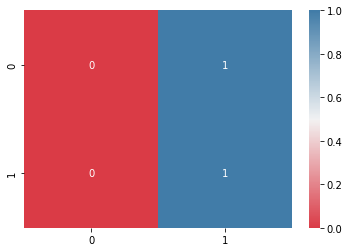

In [48]:
cm = confusion_matrix(y_true=y_val,y_pred=y_pred2,normalize='true')

cmap = sns.diverging_palette(10, 240, as_cmap=True)
print(classification_report(y_true=y_val,y_pred=y_pred2))
sns.heatmap(cm,cmap=cmap, annot=True)